# Hands On Instrument Data Reading

Please refer to [this notebook](https://github.com/arqus-gamma/arqus_school_2022/blob/main/hands_on/1_read_data/Read_data_with_astropy_hands_on.ipynb) for preliminary introduction

## 0. Setup

As usual, we start by installing some standards packages. We try to be minimal and install only those stricly required.
Check package versions. All examples should work with Astropy > 2.0 and Numpy > 1.11

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import astropy
from astropy import units as u
from astropy import constants as const
#from astropy.coordinates import SkyCoord
# from astropy.time import Time
from astropy.table import Table
from astropy.io import fits


print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.22.3
astropy: 5.0.4


However, in most cases, remember that for analyzing specific instruments' data, often additional packages are to be installed, that are somewhat specific of the instrument. In many cases, they are tailored functions

In [3]:
import gammapy
from gammapy.data import Observation, Observations, DataStore
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder

# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

## 1. Select data

In this part we start selecting the data of interest for the further analysis.

Let's first check what's in the data folder

In [13]:
!ls ../../data/data/

arqus_filelist.txt ic310              pks2155
crab_nebula        ngc1275


We see that we have 4 targets, as well the complete list of files. Let's open one target:


In [14]:
!ls ../../data/data/crab_nebula/

fact    fermi   hess    magic   other   veritas


Great! More than 5 instruments data for our targets. Let's start with MAGIC data:

In [16]:
!ls ../../data/data/crab_nebula/magic

hdu-index.fits.gz     run_05029747_DL3.fits
obs-index.fits.gz     run_05029748_DL3.fits


So we have two files (run): 05029747 and 05029748. Let's open one of them. 

In [44]:
#fits_file = fits.open('../../data/data/crab_nebula/magic/run_05029747_DL3.fits')
fits_file = fits.open('../../data/data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits')

Let's check the header data unit (HDU) by calling `.info()`:

In [45]:
fits_file.info()

Filename: ../../data/data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  EVENTS        1 BinTableHDU     62   12614R x 8C   [1K, 1D, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     24   1R x 2C   [1D, 1D]   
  3  RAD_MAX       1 BinTableHDU     33   1R x 5C   [28E, 28E, 1E, 1E, 28E]   
  4  EFFECTIVE AREA    1 BinTableHDU     35   1R x 5C   [40E, 40E, 1E, 1E, 40E]   
  5  ENERGY DISPERSION    1 BinTableHDU     36   1R x 7C   [40E, 40E, 28E, 28E, 1E, 1E, 1120E]   


The PRIMARY contains only a short header and no data

In [93]:
primary = fits_file['PRIMARY'] 
primary.header
#primary.data

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

Let's look at the EVENT HDU. Here are the events information. First with the header

In [139]:
events = fits_file['EVENTS'] 
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   40 / width of table in bytes                        
NAXIS2  =                12614 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

In [140]:
events.columns.names

['EVENT_ID', 'TIME', 'RA', 'DEC', 'ENERGY', 'GAMMANESS', 'DETX', 'DETY']

Of all the entries, some are worth discussing

```
OBS_ID  =              5059487 / unique observation identifier                  
TSTART  =         4.361391E+08 / [s] observation start time                     
TSTOP   =         4.361403E+08 / [s] observation end time                       
ONTIME  =                1193. / [s] total good time (sum of GTIs)              
LIVETIME=             1178.607 / [s] total effective time                       
OBS_MODE= 'POINTING'           / observation mode                               
RA_OBJ  =                49.95 / [deg] source RA                                
DEC_OBJ =             41.51167 / [deg] source DEC                               
OBS_MODE= 'Wobble  '           / observation mode                               
RA_PNT  =             49.45417 / [deg] observation pointing RA                  
DEC_PNT =             41.66806 / [deg] observation pointing DEC                 
ALT_PNT =             76.89065 / [deg] average altitude pointing                
AZ_PNT  =            -6.315182 / [deg] average azimuth pointing
```

Let's look at the data now

In [141]:
events.data

FITS_rec([(117, 4.36139122e+08, 49.01414 , 41.539272, 0.10293761, 0.9410159 ,  0.3199254 , -0.13709812),
          (138, 4.36139122e+08, 48.04316 , 42.417595, 0.06289925, 0.41138095,  1.0475081 ,  0.7366911 ),
          (210, 4.36139122e+08, 49.00081 , 41.941536, 0.04096247, 0.24814683,  0.33467507,  0.2649405 ),
          ...,
          (426, 4.36140309e+08, 49.170494, 41.202137, 0.06744559, 0.5043294 ,  0.34247163, -0.37614313),
          (478, 4.36140310e+08, 50.177387, 41.717915, 0.0437374 , 0.37424603, -0.5339482 , -0.11667869),
          (490, 4.36140310e+08, 48.7267  , 41.627644, 0.07804573, 0.8042143 ,  0.5244789 ,  0.13252883)],
         dtype=(numpy.record, [('EVENT_ID', '>i8'), ('TIME', '>f8'), ('RA', '>f4'), ('DEC', '>f4'), ('ENERGY', '>f4'), ('GAMMANESS', '>f4'), ('DETX', '>f4'), ('DETY', '>f4')]))

In [142]:
Table(events.data)

EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,DETX,DETY
int64,float64,float32,float32,float32,float32,float32,float32
117,436139121.599158,49.01414,41.539272,0.10293761,0.9410159,0.3199254,-0.13709812
138,436139121.66326886,48.04316,42.417595,0.06289925,0.41138095,1.0475081,0.7366911
210,436139121.89286935,49.00081,41.941536,0.040962473,0.24814683,0.33467507,0.2649405
233,436139121.9688521,48.99533,41.803627,0.034511823,0.32546824,0.33711714,0.12696764
337,436139122.25264156,49.906765,42.391163,0.05785944,0.7387659,-0.32914373,0.7258594
355,436139122.2984954,50.021763,41.50761,0.29707232,0.8527024,-0.43491018,-0.15557902
364,436139122.31179434,49.556606,41.83252,0.115851775,0.78795886,-0.08073081,0.16200143
365,436139122.3160477,48.488037,42.43964,0.13334548,0.88278574,0.7189447,0.75967366
395,436139122.41501117,48.45039,40.33354,0.39297318,0.9098333,0.7355171,-1.3470265


In [167]:
en  = events.data['ENERGY']
t   = events.data['TIME']
ra  = events.data['RA']
dec = events.data['DEC']
g   = events.data['GAMMANESS']
dx  = events.data['DETX']
dy  = events.data['DETY']

In [194]:
# Selection
cuts1 = events.data['GAMMANESS'] > 0.85
evt = events.data[cuts1]
print(len(events.data))
print(len(evt))

12614
2813


In [182]:
ensel = evt['ENERGY']
tsel   = evt['TIME']
rasel     = evt['RA']
decsel    = evt['DEC']
gsel = evt['GAMMANESS']
dxsel   = evt['DETX']
dysel   = evt['DETY']

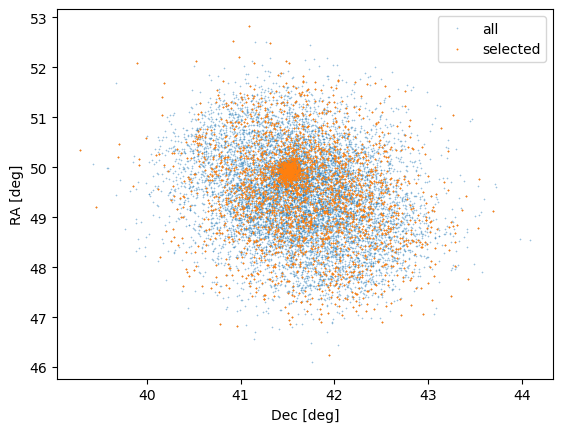

In [183]:
# Direction of the events
plt.plot(dec,ra,marker='s', markersize='0.2',linewidth='0',alpha=0.6, label="all")
plt.plot(decsel,rasel,marker='s', markersize='0.4',linewidth='0',label="selected")
plt.xlabel('Dec [deg]')
plt.ylabel('RA [deg]')
plt.legend(loc="best")

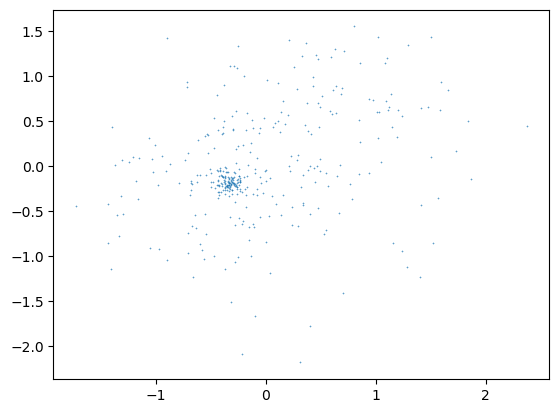

In [184]:
# Direction of the events
plt.plot(detx,dety,marker='s', markersize='0.2',linewidth='0')


(array([417., 399., 427., 359., 345., 314., 227., 184., 102.,  39.]),
 array([0.8500076 , 0.86484015, 0.87967277, 0.8945053 , 0.9093379 ,
        0.9241705 , 0.93900305, 0.9538356 , 0.96866816, 0.9835008 ,
        0.99833333], dtype=float32),
 <BarContainer object of 10 artists>)

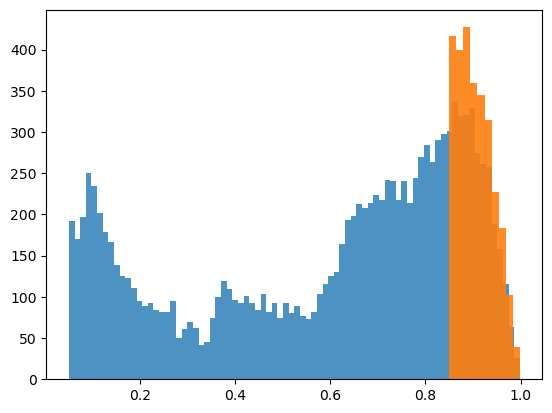

In [191]:
plt.hist(g,bins=80,alpha=0.8)
plt.hist(gsel,alpha=0.9)


Everything looks ok. For the sake of the following part we need the EVENTS tables for the moment

In [119]:
energy = events.data['ENERGY']
time = events.data['TIME']
condizione = energy > 1.05
condtemp = time >  334778850.0339344
event_sel = events.data[condizione*condtemp]
event_sel
gammaness = event_sel['GAMMANESS']
len(gammaness)
#Table(event_sel)
#plt.hist(energy, bins=1000)

31

## Effective Area

In [238]:
effarea = fits_file['EFFECTIVE AREA'] 
effarea.header
Table(effarea.data)
enlo = effarea.data['ENERG_LO']
aeff = effarea.data['EFFAREA']
x = enlo[0]
y = aeff[0][0]
x*u.TeV

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.13451366e+01, 0.00000000e+00, 3.09081249e+01, 4.75460663e+02,
       1.04630322e+03, 3.40634985e+03, 9.38467578e+03, 1.47929053e+04,
       2.53612949e+04, 3.07563223e+04, 3.47218398e+04, 4.31328555e+04,
       5.23507734e+04, 5.31981797e+04, 6.25809180e+04, 6.49979258e+04,
       8.04543672e+04, 7.66237812e+04, 8.51335078e+04, 1.00186094e+05,
       1.02929570e+05, 1.13685359e+05, 1.10281547e+05, 1.15819508e+05,
       1.14647992e+05, 1.17316633e+05, 1.08918797e+05, 1.18646195e+05,
       1.01968711e+05, 1.17116977e+05, 1.26025391e+05, 6.98853672e+04,
       7.66650234e+04, 4.31992305e+04, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)

Text(0, 0.5, 'Area [m^2]')

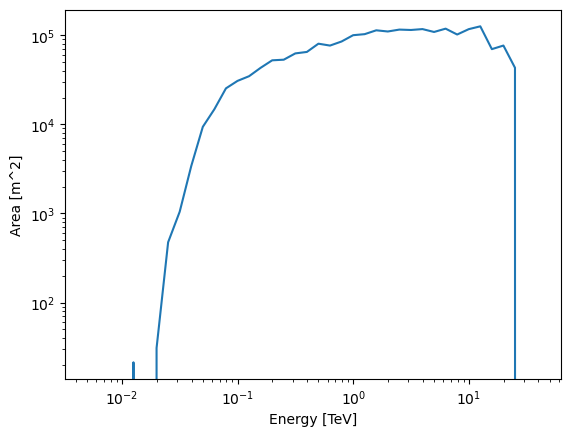

In [240]:
plt.loglog(x,y)
plt.xlabel('Energy [TeV]')
plt.ylabel('Area [m^2]')

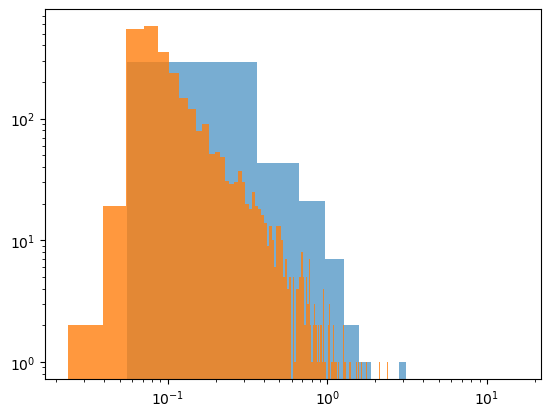

In [254]:
plt.hist(energy,bins=10,alpha=0.6,log=True)
plt.hist(ensel,bins=1000,alpha=0.8,log=True)
plt.xscale('log')